# Fake Image Detection 

## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#to generate same sequence of random numbers in whole file
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
#It is used during the training of a neural network to monitor a 
# specified metric (typically a validation metric) and stop training
#  early if certain criteria are met. The purpose of using EarlyStopping
#  is to prevent overfitting and to save time and resources when further
#  training is unlikely to improve the model's performance.
from keras.callbacks import EarlyStopping


PIL provides extensive capabilities for opening, manipulating, and saving many different image file formats.

to open image

ImageEnhance =>  can manipulate pixel colors in images, apply color mapping, and adjust brightness, contrast, and other color-related properties.

ImageChops => It provides various arithmetic and logical operations that you can perform on images.

In [2]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

## Making Dataset

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

## Convert to Error Level Analysis

In summary, this code takes an input image, compresses it, calculates the difference between the original and compressed versions, scales the difference image, and enhances its brightness. The resulting ELA image highlights areas where digital manipulation may have occurred by making the manipulated regions appear as brighter or darker areas compared to the rest of the image.

It generates ela_Image by enhancing brightness on the scale of pixel difference(difference between original and converted RGB image)

In [4]:
def convert_to_ela_image(path, quality):
    # creating a temporary filename for an intermediate image
    temp_filename = 'temp_file_name.jpg'
    # filename for ela image that will be generated
    ela_filename = 'temp_ela.png'
    
    # open image and convert to RGB
    image = Image.open(path).convert('RGB')

    # save image as jpg and keep quality as before
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    # calculate pixel difference between original image and RGB (new image) 
    # which will represents areas of image that have been altered.
    ela_image = ImageChops.difference(image, temp_image)
    
    # calculating minimum and maximum pixel values in the images
    extrema = ela_image.getextrema()

    # finds the maximum difference value among the extrema. This value is used to scale the ELA image.
    max_diff = max([ex[1] for ex in extrema])

    # ensuring max_diff is not zero to avoid division by zero.
    if max_diff == 0:
        max_diff = 1

    # calculates a scaling factor based on the maximum difference value. This factor
    # is used to stretch the ELA image's pixel values across the full 0-255 range.
    scale = 255.0 / max_diff
    
    # enhances the brightness of the ELA image by applying the previously calculated 
    # scaling factor for making the manipulated regions stand out more distinctly.
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

## Comparison of Real and Fake image( fake images in ELA form)

opening real image

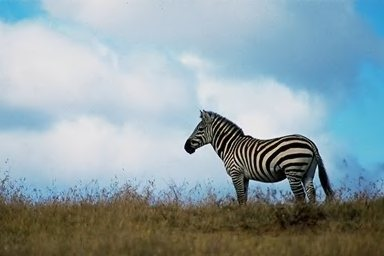

In [5]:
real_image_path = ("D:/major_project/dataset/real/Au_ani_00001.jpg")
#real_image_path = ('/content/drive/MyDrive/Colab Notebooks/Image_Detector/CASIA2/Real/Au_ani_00001.jpg')
Image.open(real_image_path)

converting real image to ela_image

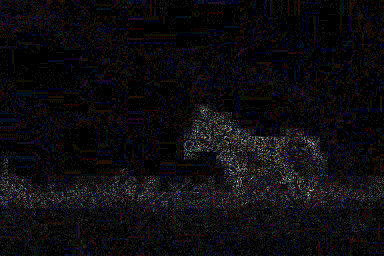

In [6]:
convert_to_ela_image(real_image_path, 90)

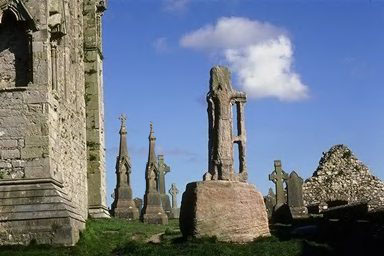

In [7]:
fake_image_path = ('D:/major_project/dataset/fake/Tp_S_NNN_S_N_arc00095_arc00095_11200.jpg')
Image.open(fake_image_path)

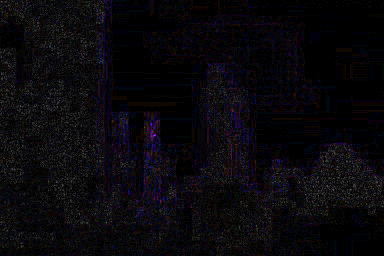

In [8]:
convert_to_ela_image(fake_image_path, 90)


## Data preparation

### Read dataset and conversion to ELA

In [9]:
image_size = (128, 128)

this function converts the image into ela_image then resize it and flattens it to store in the 1D array as CNN requires data to be in 1D array 

In [10]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [11]:
X = []
Y = []

this function processes all the files present in Au and convert them:

first into ela_image and after resizing it, it flattens the layers of image and converts in 1D array

X stores all the flattened images and Y store the count of images

In [12]:
import random
#path = 'C:/Users/swapn/Downloads/mesonet/dataset/CASIA2/Au'
path= 'D:/major_project/dataset/real'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
2100 2100


this function processes all the files present in Tp and convert them:

first into ela_image and after resizing it, it flattens the layers of image and converts in 1D array

X stores all the flattened images and Y store the count of images

now X stores all the images(Au + Tp)

In [13]:
path = 'D:/major_project/dataset/fake'
#path = '/content/drive/MyDrive/Colab Notebooks/Image_Detector/CASIA2/Fake'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
5124 5124


In [14]:
# converting X into array 
X = np.array(X)
#used when you have a target variable (labels or classes) that is represented as integers and you want to convert it into a binary matrix format suitable for training machine learning models, especially neural networks.
# In Y there are two classes 1 for real and 0 for fake so to_categorical() converts this array into 2D array of labelled classes.
# this Y will look like [[1,0],[0,1]] for 0 and 1 label.
Y = to_categorical(Y, 2)
# # Reshape image data for a convolutional neural network
#  # Batch size, height, width, channels
X = X.reshape(-1, 128, 128, 3)

Splitting the dataset into features (X) and target labels (Y)

Splitting the data into a training set (80%) and a testing set (20%)

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
# again converting 2D array to 1D array
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

4099 4099
1025 1025


# VGG16

In [30]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
import os

Load the VGG16 model with pre-trained weights (excluding the top classification layers)

In [24]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


In [26]:
# Create a sequential model and add the VGG16 base model
model = Sequential()
model.add(base_model)

# Flatten the output from the base model
model.add(Flatten())

# Add a dense layer with ReLU activation
model.add(Dense(256, activation='relu'))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add the output layer with softmax activation (2 classes: fake and real)
model.add(Dense(2, activation='softmax'))

Compiling the model

In [31]:

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Training the model

In [41]:

batch_size = 32
epochs = 5

Defining early stopping callback

In [42]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

Training the model

In [43]:

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[early_stopping])


Epoch 1/5
129/129 [==============================] - 1699s 13s/step - loss: 0.5106 - accuracy: 0.7768 - val_loss: 0.4129 - val_accuracy: 0.8410
Epoch 2/5
129/129 [==============================] - 903s 7s/step - loss: 0.4280 - accuracy: 0.8329 - val_loss: 0.3843 - val_accuracy: 0.8556
Epoch 3/5
129/129 [==============================] - 651s 5s/step - loss: 0.4261 - accuracy: 0.8341 - val_loss: 0.3609 - val_accuracy: 0.8673
Epoch 4/5
129/129 [==============================] - 685s 5s/step - loss: 0.4028 - accuracy: 0.8475 - val_loss: 0.4110 - val_accuracy: 0.8234
Epoch 5/5
129/129 [==============================] - 684s 5s/step - loss: 0.3970 - accuracy: 0.8475 - val_loss: 0.3529 - val_accuracy: 0.8663


Calculating the accuracy on validation set

In [44]:

accuracy = model.evaluate(X_val, Y_val, verbose=0)[1]
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

Validation Accuracy: 86.63%


Saving the model

In [45]:

model.save('model_vgg16_fake_detection.h5')

C:\Users\swapn\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
